In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [ ]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df.isna().sum()

Passengers    0
dtype: int64

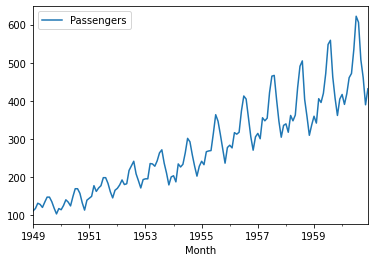

In [ ]:
df.plot();

In [ ]:
alpha = 0.2

In [ ]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [ ]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

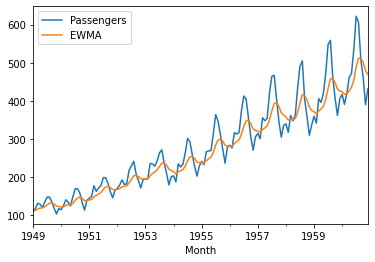

In [ ]:
df.plot();

In [ ]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

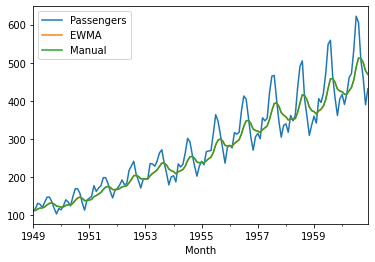

In [ ]:
df.plot();

In [ ]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [ ]:
df.drop('Manual', axis=1, inplace=True)

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [ ]:
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [ ]:
df.index.freq = 'MS'

In [ ]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [ ]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [ ]:
res

In [ ]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [ ]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [ ]:
np.allclose(df['SES'], res.fittedvalues)

True

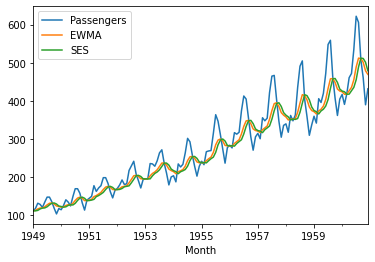

In [ ]:
df.plot();

In [ ]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [ ]:
df['SES-1'] = df['SES'].shift(-1)

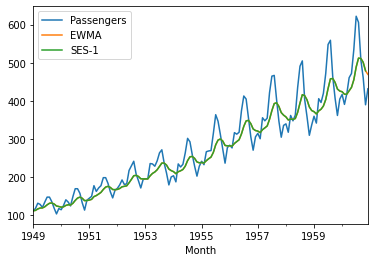

In [ ]:
### No!
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [ ]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [ ]:
ses = SimpleExpSmoothing(train['Passengers'])
res = ses.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  


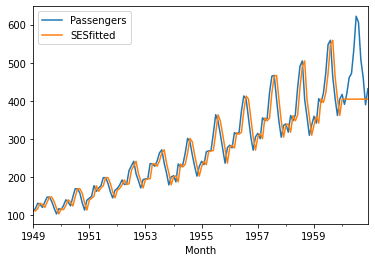

In [ ]:
df.loc[:-N_test, 'SESfitted'] = res.fittedvalues
df.loc[-N_test:, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [ ]:
res.params

{'damping_trend': nan,
 'initial_level': 112.0,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': nan,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.995,
 'smoothing_seasonal': nan,
 'smoothing_trend': nan,
 'use_boxcox': False}

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
holt = Holt(df['Passengers'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [ ]:
res_h = holt.fit()

In [ ]:
df['Holt'] = res_h.fittedvalues

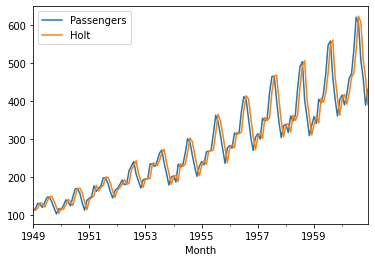

In [ ]:
df[['Passengers', 'Holt']].plot();

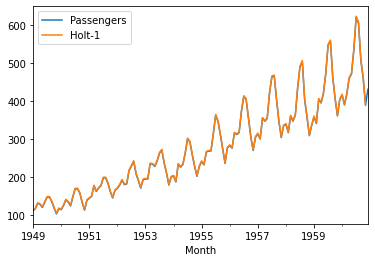

In [ ]:
### No!
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot();

In [ ]:
holt = Holt(train['Passengers'])
res_h = holt.fit()
df.loc[:-N_test, 'Holt'] = res_h.fittedvalues

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df.loc[-N_test:, 'Holt'] = res_h.forecast(N_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """Entry point for launching an IPython kernel.


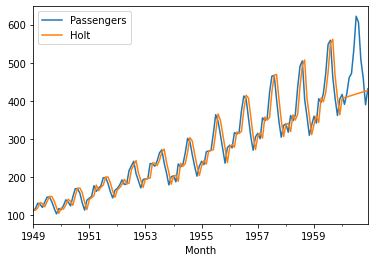

In [ ]:
df[['Passengers', 'Holt']].plot();

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
hw = ExponentialSmoothing(train['Passengers'], \
                          trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [ ]:
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """Entry point for launching an IPython kernel.


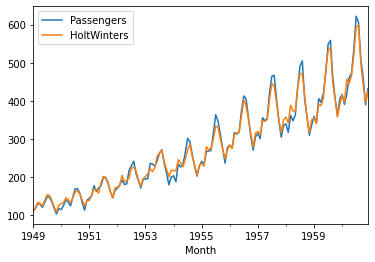

In [ ]:
df[['Passengers', 'HoltWinters']].plot();

In [ ]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

In [ ]:
def mae(y, t):
  return np.mean(np.abs(y - t))

In [ ]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.62468020352184
Test RMSE: 16.980141553924987


In [ ]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 9.008020518796009
Test MAE: 13.380801732365692


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  after removing the cwd from sys.path.


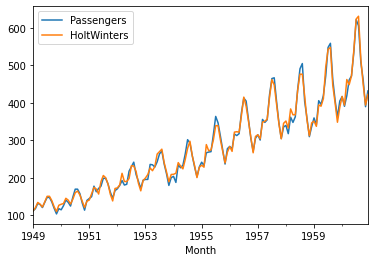

In [ ]:
hw = ExponentialSmoothing(train['Passengers'], \
                          trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [ ]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.767995558539946
Test RMSE: 15.810835822154257


In [ ]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.604312485557862
Test MAE: 10.30364155047729


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  after removing the cwd from sys.path.


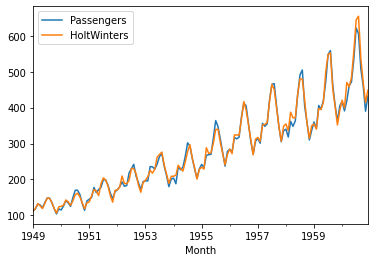

In [ ]:
hw = ExponentialSmoothing(train['Passengers'], \
                          trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [ ]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.617924854512014
Test RMSE: 25.806200661564787


In [ ]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.112440059345803
Test MAE: 20.84421181140488


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  after removing the cwd from sys.path.


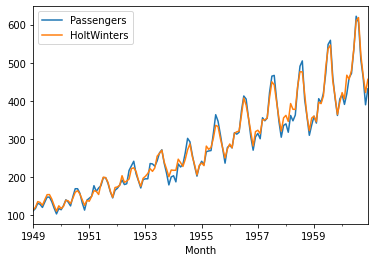

In [ ]:
hw = ExponentialSmoothing(train['Passengers'], \
                          trend='mul', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [ ]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.671459037171298
Test RMSE: 19.94862742675839


In [ ]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 8.95065051418485
Test MAE: 14.947619133690571


By using a state space formulation, we can perform simulations of future values. The mathematical details are described in Hyndman and Athanasopoulos [2] and in the documentation of HoltWintersResults.simulate.

Similar to the example in [2], we use the model with additive trend, multiplicative seasonality, and multiplicative error. We simulate up to 8 steps into the future, and perform 1000 simulations. As can be seen in the below figure, the simulations match the forecast values quite well.

[2] [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice, 2nd edition. OTexts, 2018.](https://otexts.com/fpp2/ets.html)

In [ ]:
#!pip install statsmodels==0.12.1

In [ ]:
import statsmodels
print(statsmodels.__version__)

0.12.1


In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt

In [ ]:
train.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1959-03-01', '1959-04-01', '1959-05-01', '1959-06-01',
               '1959-07-01', '1959-08-01', '1959-09-01', '1959-10-01',
               '1959-11-01', '1959-12-01'],
              dtype='datetime64[ns]', name='Month', length=132, freq='MS')

{'smoothing_level': 0.2511578079974295, 'smoothing_trend': 1.807531231162649e-06, 'smoothing_seasonal': 0.7488267545535716, 'damping_trend': nan, 'initial_level': 118.53284646310544, 'initial_trend': 2.5575386314282103, 'initial_seasons': array([ -9.13380885,  -3.51351379,   9.01136508,   3.74493899,
        -4.96315501,   9.18243773,  21.40778824,  18.91592593,
         4.65555666, -14.30203267, -28.86991891, -12.30179717]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


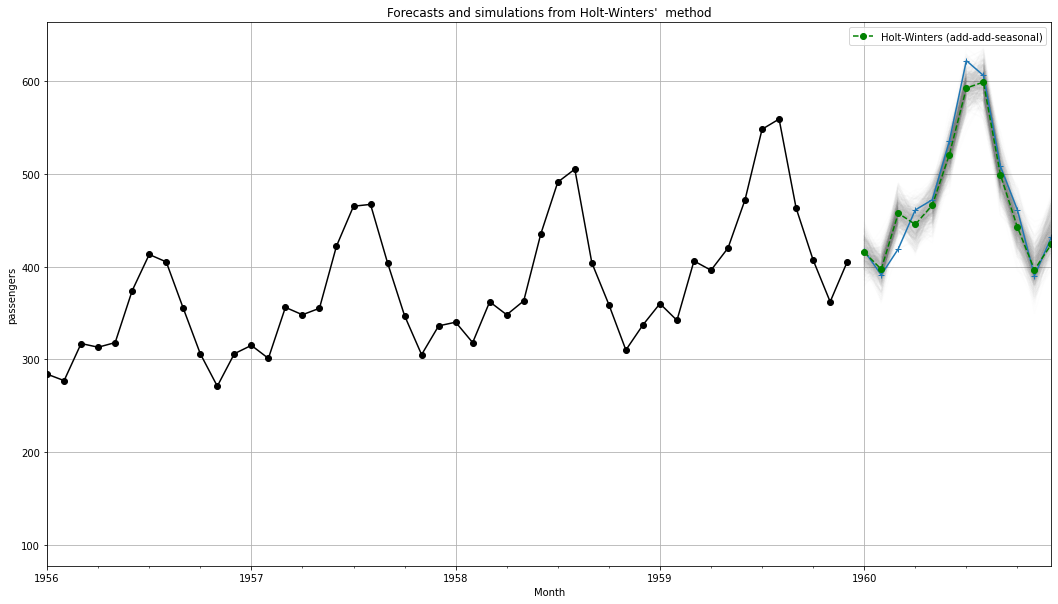

In [ ]:
fit = ExponentialSmoothing(train['Passengers'], seasonal_periods=12, trend='add', seasonal='add', initialization_method="estimated").fit()
print(fit.params)
simulations = fit.simulate(N_test, repetitions=500, error='add')

ax = train['Passengers'].plot(figsize=(18,10), marker='o', color='black',
               title="Forecasts and simulations from Holt-Winters'  method" )
#test['Passengers'].iloc[:N_test].plot(ax=ax,marker='+',color='blue',legend=True,label='Test Data')
ax.set_ylabel("passengers")
ax.set_xlabel("Month")
#fit.fittedvalues.plot(ax=ax, style='--', color='green')
simulations.plot(ax=ax, style='-', alpha=0.01, color='grey', legend=False)
test['Passengers'].plot(ax=ax,marker='+')
#print(fit.forecast(N_test))
#print(simulations)
fit.forecast(N_test).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
ax.grid(True)
ax.set_xlim(('1956-01-01',str(test.index.max())))

plt.show()